In [55]:
import os

os.environ['SPARK_VERSION'] = '3.3'

from pyspark.sql import SparkSession, Row
import pydeequ
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *
import time
import matplotlib.pyplot as plt
from pydeequ.analyzers import *

# Now, you can proceed with your SparkSession setup and the rest of your code
spark = (SparkSession
    .builder
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .config("spark.scheduler.maxRegisteredResourcesWaitingTime", "5000")
    .config("spark.scheduler.minRegisteredResourcesRatio", "1.0")
    .config("spark.sql.debug.maxToStringFields", "100")
    .appName("test_completeness") \
    .getOrCreate())


# Dataset kc_house

In [56]:
df = spark.read.csv("kc_house_data.csv", header=True, inferSchema=True)

In [57]:
import os

# Replace this with the path to your file
file_path = 'kc_house_data.csv'

# Getting the size of the file
file_size = os.path.getsize(file_path)

print(f"The size of the file is: {file_size} bytes")

The size of the file is: 2515206 bytes


In [58]:
affichage = []
for i in range(1,6):
    affichage.append(round(file_size * 0.2 * i))
print(affichage)

[503041, 1006082, 1509124, 2012165, 2515206]


## Completeness






[0.1477961540222168, 0.2611715793609619, 0.5757007598876953, 1.1782634258270264, 2.460360288619995]
[{'check_status': 'Success', 'check_level': 'Warning', 'constraint_status': 'Success', 'check': 'Data Completeness Check', 'constraint_message': '', 'constraint': 'CompletenessConstraint(Completeness(id,None))'}]


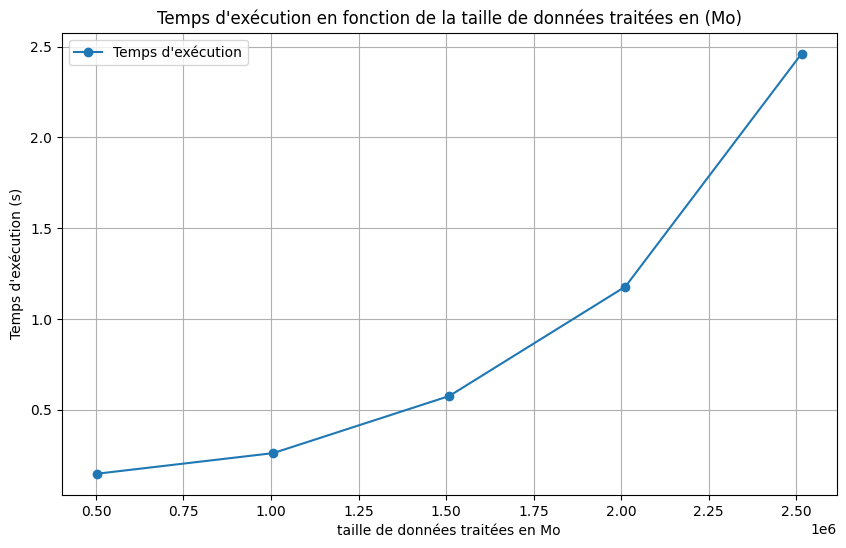

In [59]:
# Charger les données dans un DataFrame Spark
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_batch_complete_id = []
completeness_results = []

# Au lieu d'initialiser avec une liste vide, utilisez les données existantes et limitez à 0
accumulated_data = data.limit(0)

for i in range(1, 6):
    # Sélectionner le sous-ensemble de données à ajouter
    subset_size = int(total_count * 0.2 * i)
    new_data = data.limit(subset_size).subtract(accumulated_data).cache()
    new_data.count()  # Force le cache et l'évaluation

    # Accumuler les données
    accumulated_data = accumulated_data.union(new_data).cache()

    # Définir la vérification de la complétude
    check = Check(spark, CheckLevel.Warning, "Data Completeness Check")
    
    # Démarrer le chronomètre
    start_time = time.time()
    
    # Exécuter la vérification
    verification_result = VerificationSuite(spark) \
        .onData(accumulated_data) \
        .addCheck(check.isComplete("id")) \
        .run()
    end_time = time.time()
    elapsed_time = end_time - start_time
    times_batch_complete_id.append(elapsed_time)  # Ajouter le temps d'exécution à la liste 'times'

    # Détails sur les résultats
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'CompletenessConstraint' in result['constraint']:
                completeness_status = result['constraint_status']  # 'Success' or 'Failure'
                completeness_message = result['constraint_message']
                print(completeness_message)
                if completeness_message != "" :
                # Extract the completeness value from the message
                # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    completeness_value = float(completeness_message.split('Value: ')[1].split(' ')[0])
                
                    completeness_results.append(completeness_value)

    # Libérer la mémoire
    new_data.unpersist()
    accumulated_data.unpersist()

print(times_batch_complete_id)
print(check_results)
# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch_complete_id, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

## Uniqueness

[0.1860508918762207, 0.7200093269348145, 0.9604568481445312, 1.6439783573150635, 3.4322762489318848]
[{'check_status': 'Warning', 'check_level': 'Warning', 'constraint_status': 'Failure', 'check': 'Data Uniqueness Check', 'constraint_message': 'Value: 0.9836672373108777 does not meet the constraint requirement!', 'constraint': 'UniquenessConstraint(Uniqueness(List(id),None))'}]


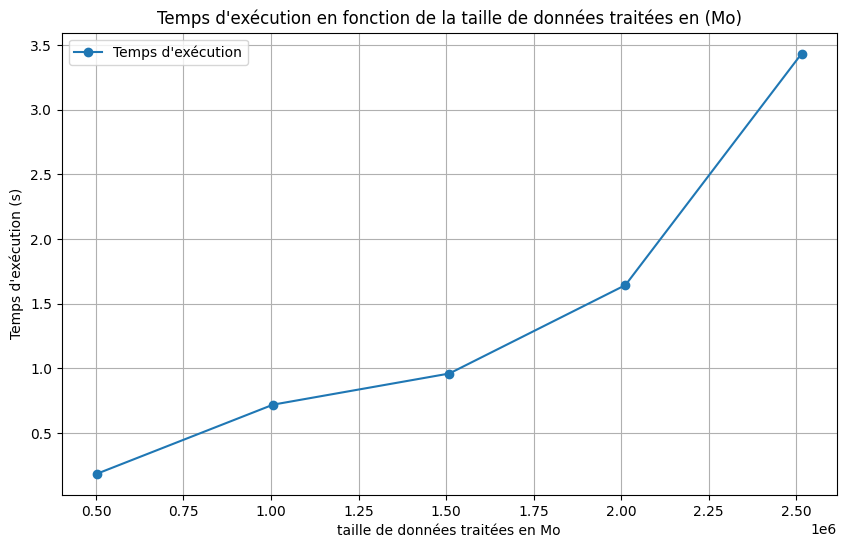

In [60]:
# Charger les données dans un DataFrame Spark
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_batch_unique_id = []
Uniqueness_results = []

# Au lieu d'initialiser avec une liste vide, utilisez les données existantes et limitez à 0
accumulated_data = data.limit(0)

for i in range(1, 6):
    # Sélectionner le sous-ensemble de données à ajouter
    subset_size = int(total_count * 0.2 * i)
    new_data = data.limit(subset_size).subtract(accumulated_data).cache()
    new_data.count()  # Force le cache et l'évaluation

    # Accumuler les données
    accumulated_data = accumulated_data.union(new_data).cache()

    # Définir la vérification de la complétude
    check = Check(spark, CheckLevel.Warning, "Data Uniqueness Check")
    Uniqueness_check = check.isUnique("id")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()

    # Exécuter la vérification
    verification_result = VerificationSuite(spark) \
        .onData(accumulated_data) \
        .addCheck(Uniqueness_check) \
        .run()
    end_time = time.time()
    elapsed_time = end_time - start_time
    times_batch_unique_id.append(elapsed_time)  # Ajouter le temps d'exécution à la liste 'times'

    # Détails sur les résultats
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'UniquenessConstraint' in result['constraint']:
                Uniqueness_status = result['constraint_status']  # 'Success' or 'Failure'
                Uniqueness_message = result['constraint_message']
                if Uniqueness_message != "":
                    # Extract the completeness value from the message
                    # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    Uniqueness_value = float(Uniqueness_message.split('Value: ')[1].split(' ')[0])
                    
                    Uniqueness_results.append(Uniqueness_value)

    # Libérer la mémoire
    new_data.unpersist()
    accumulated_data.unpersist()

print(times_batch_unique_id)
print(check_results)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch_unique_id, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

## Non-negative

[0.13561129570007324, 0.3493790626525879, 0.7095956802368164, 0.957838773727417, 2.4567553997039795]
[{'check_status': 'Success', 'check_level': 'Warning', 'constraint_status': 'Success', 'check': 'Data Non negative Check', 'constraint_message': '', 'constraint': 'ComplianceConstraint(Compliance(price is non-negative,COALESCE(CAST(price AS DECIMAL(20,10)), 0.0) >= 0,None))'}]


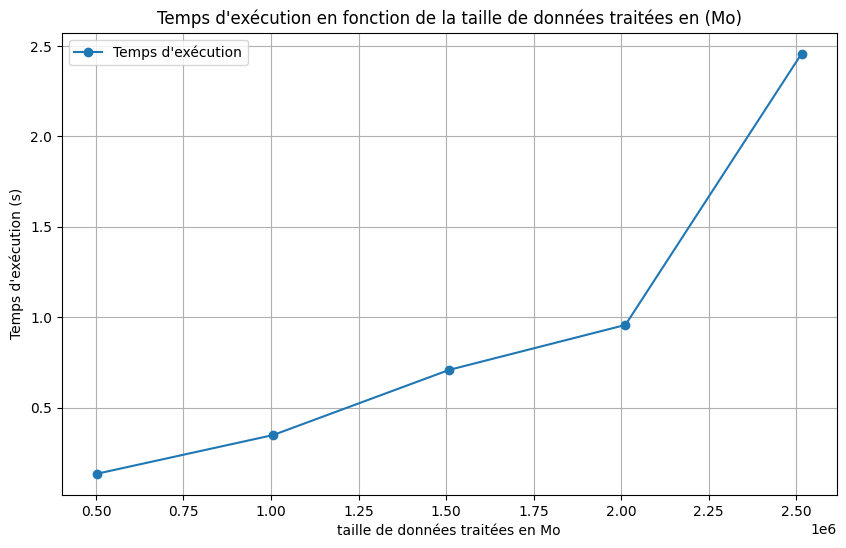

In [61]:
# Charger les données dans un DataFrame Spark
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_batch_nn_price = []
NN_results = []

# Au lieu d'initialiser avec une liste vide, utilisez les données existantes et limitez à 0
accumulated_data = data.limit(0)

for i in range(1, 6):
    # Sélectionner le sous-ensemble de données à ajouter
    subset_size = int(total_count * 0.2 * i)
    new_data = data.limit(subset_size).subtract(accumulated_data).cache()
    new_data.count()  # Force le cache et l'évaluation

    # Accumuler les données
    accumulated_data = accumulated_data.union(new_data).cache()

    # Définir la vérification de la complétude
    check = Check(spark, CheckLevel.Warning, "Data Non negative Check")
    
    # Démarrer le chronomètre
    start_time = time.time()
    
    # Exécuter la vérification
    verification_result = VerificationSuite(spark) \
        .onData(accumulated_data) \
        .addCheck(check.isNonNegative("price")) \
        .run()
    end_time = time.time()
    elapsed_time = end_time - start_time
    times_batch_nn_price.append(elapsed_time)  # Ajouter le temps d'exécution à la liste 'times'

    # Détails sur les résultats
    check_results = verification_result.checkResults
    
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'ComplianceConstraint' in result['constraint']:
                compliance_status = result['constraint_status']  # 'Success' or 'Failure'
                compliance_message = result['constraint_message']
                if compliance_message != "" :
                # Extract the completeness value from the message
                # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    compliance_value = float(compliance_message.split('Value: ')[1].split(' ')[0])
                
                    NN_results.append(compliance_value)

    # Libérer la mémoire
    new_data.unpersist()
    accumulated_data.unpersist()

print(times_batch_nn_price)
print(check_results)
# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch_nn_price, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

# Dataset Chicago Taxi Trips

In [62]:
df = spark.read.csv("chicago_taxi_trips_2016_01.csv", header=True, inferSchema=True)

In [63]:
import os

# Replace this with the path to your file
file_path = 'chicago_taxi_trips_2016_01.csv'

# Getting the size of the file
file_size = os.path.getsize(file_path)

print(f"The size of the file is: {file_size} bytes")

The size of the file is: 184423109 bytes


In [64]:
affichage = []
for i in range(1,6):
    affichage.append(round(file_size * 0.2 * i))
print(affichage)

[36884622, 73769244, 110653865, 147538487, 184423109]


## Completeness

[0.14009332656860352, 0.06068134307861328, 0.12528681755065918, 0.07291936874389648, 0.09317898750305176]
[{'check_status': 'Warning', 'check_level': 'Warning', 'constraint_status': 'Failure', 'check': 'Data Completeness Check', 'constraint_message': 'Value: 0.999982375438411 does not meet the constraint requirement!', 'constraint': 'CompletenessConstraint(Completeness(taxi_id,None))'}]


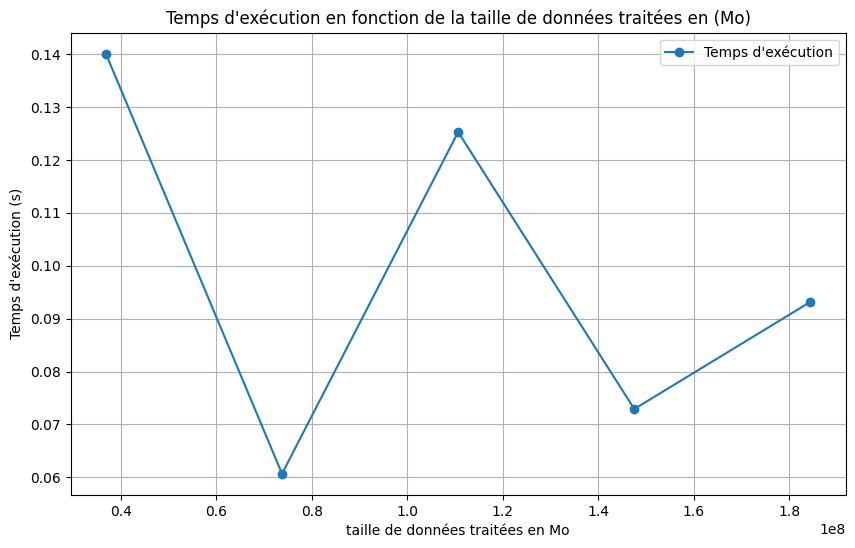

In [65]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *

# Supposons que la SparkSession est déjà créée et configurée
# ...

# Charger les données dans un DataFrame Spark et les cacher
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_incremental_tid = []
Completeness_results = []

# Traiter les données par segments de 20% sans retraitement
for i in range(1, 6):
    # Calculer la fin du segment actuel
    segment_end = int(total_count * 0.2 * i)
    
    # Sélectionner uniquement le segment actuel de données
    current_segment = data.limit(segment_end).subtract(data.limit(segment_end - int(total_count * 0.2))).cache()
    
    # Forcer l'évaluation du segment actuel
    current_segment.count() 

    # Définir la vérification de la complétude pour le segment actuel
    check = Check(spark, CheckLevel.Warning, "Data Completeness Check")
    Completeness_check = check.isComplete("taxi_id")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()
    
    # Exécuter la vérification de la complétude pour le segment actuel
    verification_result = VerificationSuite(spark) \
        .onData(current_segment) \
        .addCheck(Completeness_check) \
        .run()
    end_time = time.time()
    
    # Calculer et enregistrer le temps écoulé
    elapsed_time = end_time - start_time
    times_incremental_tid.append(elapsed_time)

    # Libérer la mémoire
    current_segment.unpersist()

    # Détails sur les résultats de complétude pour le segment actuel
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'CompletenessConstraint' in result['constraint']:
                Completeness_status = result['constraint_status']  # 'Success' or 'Failure'
                Completeness_message = result['constraint_message']
                if Completeness_message != "" :
                    # Extract the completeness value from the message
                    # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    Completeness_value = float(Completeness_message.split('Value: ')[1].split(' ')[0])
                    
                    Completeness_results.append(Completeness_value)

print(times_incremental_tid)
print(check_results)
# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_incremental_tid, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

# Uniqueness

[0.24364137649536133, 0.17039847373962402, 0.27571702003479004, 0.2641143798828125, 0.17984986305236816]
[{'check_status': 'Warning', 'check_level': 'Warning', 'constraint_status': 'Failure', 'check': 'Data Uniqueness Check', 'constraint_message': 'Value: 7.138073248968945E-4 does not meet the constraint requirement!', 'constraint': 'UniquenessConstraint(Uniqueness(List(taxi_id),None))'}]


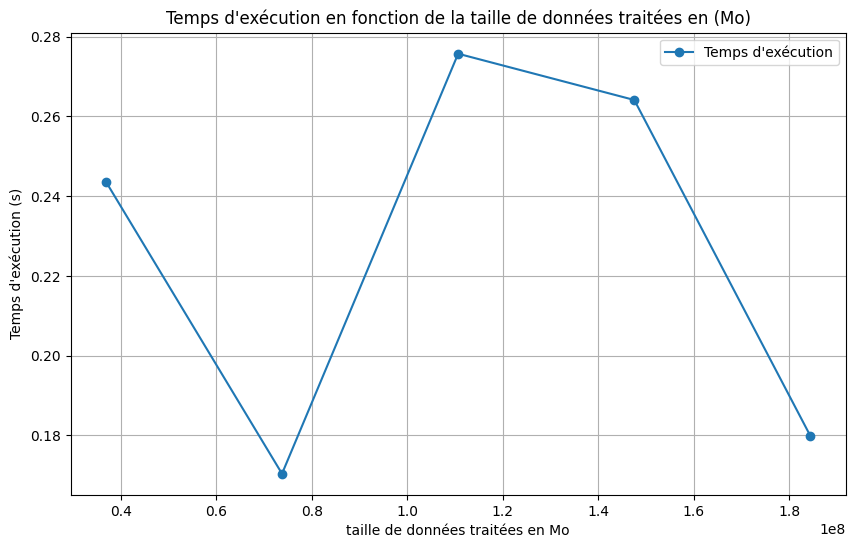

In [66]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *

# Supposons que la SparkSession est déjà créée et configurée
# ...

# Charger les données dans un DataFrame Spark et les cacher
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_incremental_unique_tid = []
Uniqueness_results = []

# Traiter les données par segments de 20% sans retraitement
for i in range(1, 6):
    # Calculer la fin du segment actuel
    segment_end = int(total_count * 0.2 * i)
    
    # Sélectionner uniquement le segment actuel de données
    current_segment = data.limit(segment_end).subtract(data.limit(segment_end - int(total_count * 0.2))).cache()
    
    # Forcer l'évaluation du segment actuel
    current_segment.count() 

    # Définir la vérification de la complétude pour le segment actuel
    check = Check(spark, CheckLevel.Warning, "Data Uniqueness Check")
    Uniqueness_check = check.isUnique("taxi_id")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()
    
    # Exécuter la vérification de la complétude pour le segment actuel
    verification_result = VerificationSuite(spark) \
        .onData(current_segment) \
        .addCheck(Uniqueness_check) \
        .run()
    end_time = time.time()
    
    # Calculer et enregistrer le temps écoulé
    elapsed_time = end_time - start_time
    times_incremental_unique_tid.append(elapsed_time)

    # Libérer la mémoire
    current_segment.unpersist()

    # Détails sur les résultats de complétude pour le segment actuel
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'UniquenessConstraint' in result['constraint']:
                Uniqueness_status = result['constraint_status']  # 'Success' or 'Failure'
                Uniqueness_message = result['constraint_message']
                if Uniqueness_message != "" :
                    # Extract the completeness value from the message
                    # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    Uniqueness_value = float(Uniqueness_message.split('Value: ')[1].split(' ')[0])
                    
                    Uniqueness_results.append(Uniqueness_value)

print(times_incremental_unique_tid)
print(check_results)
# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_incremental_unique_tid, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

## Non-negative

[0.09721899032592773, 0.09707188606262207, 0.09572839736938477, 0.09490513801574707, 0.09051227569580078]
[{'check_status': 'Success', 'check_level': 'Warning', 'constraint_status': 'Success', 'check': 'Data Compliance Check', 'constraint_message': '', 'constraint': 'ComplianceConstraint(Compliance(taxi_id is non-negative,COALESCE(CAST(taxi_id AS DECIMAL(20,10)), 0.0) >= 0,None))'}]


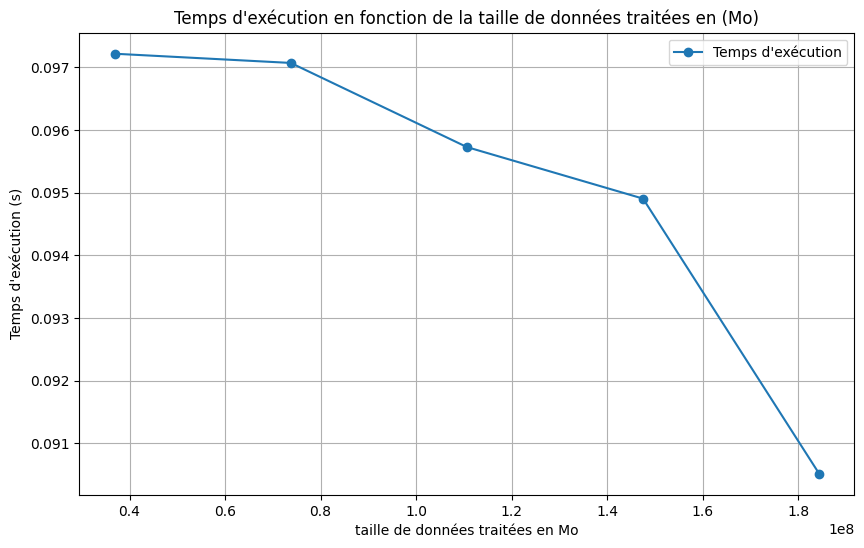

In [67]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *

# Supposons que la SparkSession est déjà créée et configurée
# ...

# Charger les données dans un DataFrame Spark et les cacher
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_incremental_compliance_tid = []
Compliance_results = []

# Traiter les données par segments de 20% sans retraitement
for i in range(1, 6):
    # Calculer la fin du segment actuel
    segment_end = int(total_count * 0.2 * i)
    
    # Sélectionner uniquement le segment actuel de données
    current_segment = data.limit(segment_end).subtract(data.limit(segment_end - int(total_count * 0.2))).cache()
    
    # Forcer l'évaluation du segment actuel
    current_segment.count() 

    # Définir la vérification de la complétude pour le segment actuel
    check = Check(spark, CheckLevel.Warning, "Data Compliance Check")
    Uniqueness_check = check.isNonNegative("taxi_id")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()
    
    # Exécuter la vérification de la complétude pour le segment actuel
    verification_result = VerificationSuite(spark) \
        .onData(current_segment) \
        .addCheck(Uniqueness_check) \
        .run()
    end_time = time.time()
    
    # Calculer et enregistrer le temps écoulé
    elapsed_time = end_time - start_time
    times_incremental_compliance_tid.append(elapsed_time)

    # Libérer la mémoire
    current_segment.unpersist()

    # Détails sur les résultats de complétude pour le segment actuel
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'ComplianceConstraint' in result['constraint']:
                Compliance_status = result['constraint_status']  # 'Success' or 'Failure'
                Compliance_message = result['constraint_message']
                if Compliance_message != "" :
                    # Extract the completeness value from the message
                    # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    Compliance_value = float(Compliance_message.split('Value: ')[1].split(' ')[0])
                    
                    Compliance_results.append(Compliance_value)

print(times_incremental_compliance_tid)
print(check_results)
# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_incremental_compliance_tid, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

## Steel industry dataset 

In [68]:
df = spark.read.csv("Steel_industry_data.csv", header=True, inferSchema=True)

In [69]:
import os

# Replace this with the path to your file
file_path = 'Steel_industry_data.csv'

# Getting the size of the file
file_size = os.path.getsize(file_path)

print(f"The size of the file is: {file_size} bytes")

The size of the file is: 2731389 bytes


In [70]:
affichage = []
for i in range(1,6):
    affichage.append(round(file_size * 0.2 * i))
print(affichage)

[546278, 1092556, 1638833, 2185111, 2731389]


# Completeness

[0.04972577095031738, 0.03778839111328125, 0.03987860679626465, 0.04182910919189453, 0.05132484436035156]
[{'check_status': 'Success', 'check_level': 'Warning', 'constraint_status': 'Success', 'check': 'Data Completeness Check', 'constraint_message': '', 'constraint': 'CompletenessConstraint(Completeness(date,None))'}]


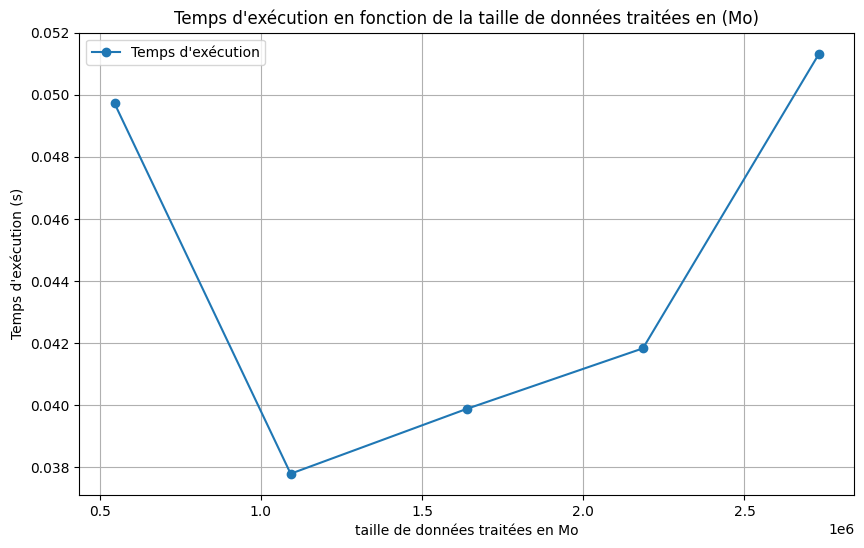

In [71]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *

# Supposons que la SparkSession est déjà créée et configurée
# ...

# Charger les données dans un DataFrame Spark et les cacher
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_incremental_complete_date = []
Completeness_results = []

# Traiter les données par segments de 20% sans retraitement
for i in range(1, 6):
    # Calculer la fin du segment actuel
    segment_end = int(total_count * 0.2 * i)
    
    # Sélectionner uniquement le segment actuel de données
    current_segment = data.limit(segment_end).subtract(data.limit(segment_end - int(total_count * 0.2))).cache()
    
    # Forcer l'évaluation du segment actuel
    current_segment.count() 

    # Définir la vérification de la complétude pour le segment actuel
    check = Check(spark, CheckLevel.Warning, "Data Completeness Check")
    Completeness_check = check.isComplete("date")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()
    
    # Exécuter la vérification de la complétude pour le segment actuel
    verification_result = VerificationSuite(spark) \
        .onData(current_segment) \
        .addCheck(Completeness_check) \
        .run()
    end_time = time.time()
    
    # Calculer et enregistrer le temps écoulé
    elapsed_time = end_time - start_time
    times_incremental_complete_date.append(elapsed_time)

    # Libérer la mémoire
    current_segment.unpersist()

    # Détails sur les résultats de complétude pour le segment actuel
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'CompletenessConstraint' in result['constraint']:
                Completeness_status = result['constraint_status']  # 'Success' or 'Failure'
                Completeness_message = result['constraint_message']
                if Completeness_message != "" :
                    # Extract the completeness value from the message
                    # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    Completeness_value = float(Completeness_message.split('Value: ')[1].split(' ')[0])
                    
                    Completeness_results.append(Completeness_value)

print(times_incremental_complete_date)
print(check_results)
# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_incremental_complete_date, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

# Uniqueness

[0.14568591117858887, 0.10819602012634277, 0.11191964149475098, 0.10858607292175293, 0.37587714195251465]
[{'check_status': 'Success', 'check_level': 'Warning', 'constraint_status': 'Success', 'check': 'Data Uniqueness Check', 'constraint_message': '', 'constraint': 'UniquenessConstraint(Uniqueness(List(date),None))'}]


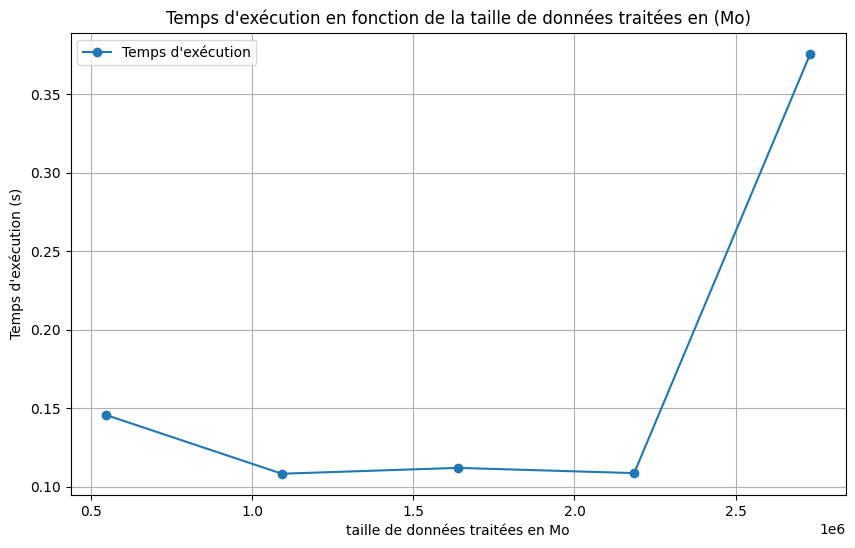

In [72]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *

# Supposons que la SparkSession est déjà créée et configurée
# ...

# Charger les données dans un DataFrame Spark et les cacher
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_incremental_unique_date = []
Uniqueness_results = []

# Traiter les données par segments de 20% sans retraitement
for i in range(1, 6):
    # Calculer la fin du segment actuel
    segment_end = int(total_count * 0.2 * i)
    
    # Sélectionner uniquement le segment actuel de données
    current_segment = data.limit(segment_end).subtract(data.limit(segment_end - int(total_count * 0.2))).cache()
    
    # Forcer l'évaluation du segment actuel
    current_segment.count() 

    # Définir la vérification de la complétude pour le segment actuel
    check = Check(spark, CheckLevel.Warning, "Data Uniqueness Check")
    Uniqueness_check = check.isUnique("date")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()
    
    # Exécuter la vérification de la complétude pour le segment actuel
    verification_result = VerificationSuite(spark) \
        .onData(current_segment) \
        .addCheck(Uniqueness_check) \
        .run()
    end_time = time.time()
    
    # Calculer et enregistrer le temps écoulé
    elapsed_time = end_time - start_time
    times_incremental_unique_date.append(elapsed_time)

    # Libérer la mémoire
    current_segment.unpersist()

    # Détails sur les résultats de complétude pour le segment actuel
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'UniquenessConstraint' in result['constraint']:
                Uniqueness_status = result['constraint_status']  # 'Success' or 'Failure'
                Uniqueness_message = result['constraint_message']
                if Uniqueness_message != "" :
                    # Extract the completeness value from the message
                    # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    Uniqueness_value = float(Uniqueness_message.split('Value: ')[1].split(' ')[0])
                    
                    Uniqueness_results.append(Uniqueness_value)

print(times_incremental_unique_date)
print(check_results)
# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_incremental_unique_date, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

# Non negative

[0.11591720581054688, 0.18299293518066406, 0.5914735794067383, 1.26786470413208, 2.6111831665039062]
[{'check_status': 'Success', 'check_level': 'Warning', 'constraint_status': 'Success', 'check': 'Data Non negative Check', 'constraint_message': '', 'constraint': 'ComplianceConstraint(Compliance(NSM is non-negative,COALESCE(CAST(NSM AS DECIMAL(20,10)), 0.0) >= 0,None))'}]


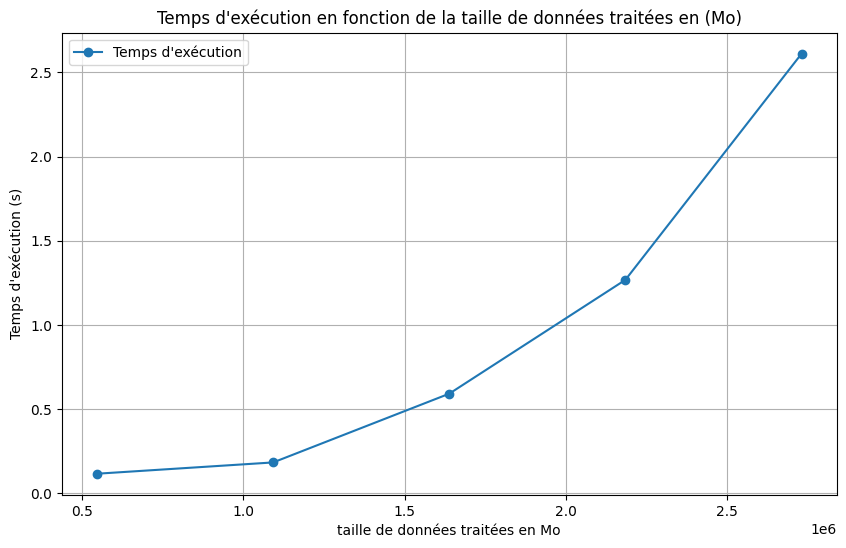

In [73]:
# Charger les données dans un DataFrame Spark
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_batch_nn_NSM = []
NN_results = []

# Au lieu d'initialiser avec une liste vide, utilisez les données existantes et limitez à 0
accumulated_data = data.limit(0)

for i in range(1, 6):
    # Sélectionner le sous-ensemble de données à ajouter
    subset_size = int(total_count * 0.2 * i)
    new_data = data.limit(subset_size).subtract(accumulated_data).cache()
    new_data.count()  # Force le cache et l'évaluation

    # Accumuler les données
    accumulated_data = accumulated_data.union(new_data).cache()

    # Définir la vérification de la complétude
    check = Check(spark, CheckLevel.Warning, "Data Non negative Check")
    
    # Démarrer le chronomètre
    start_time = time.time()
    
    # Exécuter la vérification
    verification_result = VerificationSuite(spark) \
        .onData(accumulated_data) \
        .addCheck(check.isNonNegative("NSM")) \
        .run()
    end_time = time.time()
    elapsed_time = end_time - start_time
    times_batch_nn_NSM.append(elapsed_time)  # Ajouter le temps d'exécution à la liste 'times'

    # Détails sur les résultats
    check_results = verification_result.checkResults
    
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'ComplianceConstraint' in result['constraint']:
                compliance_status = result['constraint_status']  # 'Success' or 'Failure'
                compliance_message = result['constraint_message']
                if compliance_message != "" :
                # Extract the completeness value from the message
                # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    compliance_value = float(compliance_message.split('Value: ')[1].split(' ')[0])
                
                    NN_results.append(compliance_value)

    # Libérer la mémoire
    new_data.unpersist()
    accumulated_data.unpersist()

print(times_batch_nn_NSM)
print(check_results)
# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch_nn_NSM, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()